<a href="https://colab.research.google.com/github/deepakri201/SEG_and_SR_for_NLSTSeg/blob/main/technical_validation_volume/technical_validation_volume.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Technical validation of volume

Compare the volume from pyradiomics SRs to the volumes reported from the Excel spreadsheets.

Deepa Krishnaswamy

Brigham and Women's Hospital

October 2025

In [ ]:
# output_seg_bucket = "gs://seg_nlst"
input_bucket = "gs://nlstseg" # holds the actual tables and raw data
output_bucket = "gs://nlstseg_seg_and_sr" # holds the output SEG and SR

In [ ]:
!pip install --no-cache-dir git+https://github.com/AIM-Harvard/pyradiomics.git

  Cloning https://github.com/AIM-Harvard/pyradiomics.git to /tmp/pip-req-build-e9lmcs8q
  Running command git clone --filter=blob:none --quiet https://github.com/AIM-Harvard/pyradiomics.git /tmp/pip-req-build-e9lmcs8q
  Resolved https://github.com/AIM-Harvard/pyradiomics.git to commit 8ed579383b44806651c463d5e691f3b2b57522ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 129.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 253.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 318.6 MB/s eta 0:00:00
  Created wheel for pyradiomics: filename=pyradiomics-3.1.1.dev111+g8ed579383-cp312-cp312-linux_x86_64.whl size=121811 sha256=c48d5d45c7f0e7e2a0c693e3a2a4c0aa220b66043c92bca17c70652b4ae577c8
  Stored in directory

# Parameterization

In [ ]:
#@title Enter your Project ID here
# initialize this variable with your Google Cloud Project ID!
project_name = "idc-external-018" #@param {type:"string"}

import os
os.environ["GCP_PROJECT_ID"] = project_name

!gcloud config set project $project_name

from google.colab import auth
auth.authenticate_user()

Updated property [core/project].


# Environment setup

In [ ]:
!pip install idc-index

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 60.5 MB/s eta 0:00:00
  Attempting uninstall: duckdb
    Found existing installation: duckdb 1.3.2
    Uninstalling duckdb-1.3.2:
      Successfully uninstalled duckdb-1.3.2


In [ ]:
from idc_index import IDCClient

idc_client = IDCClient.client()

In [ ]:
import os
import sys
import time

import numpy as np
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

import json
from pathlib import Path

from google.cloud import bigquery
from google.cloud import storage

import ast

In [ ]:
# DCMQI - to convert nifti to DICOM Segmentation object
!wget https://github.com/QIICR/dcmqi/releases/download/v1.4.0/dcmqi-1.4.0-linux.tar.gz
!tar zxvf dcmqi-1.4.0-linux.tar.gz
!cp dcmqi-1.4.0-linux/bin/* /usr/local/bin/

--2025-11-17 19:49:37--  https://github.com/QIICR/dcmqi/releases/download/v1.4.0/dcmqi-1.4.0-linux.tar.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/50675718/915cb14a-48f5-4288-9a5f-bfbcc67daf43?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-17T20%3A23%3A18Z&rscd=attachment%3B+filename%3Ddcmqi-1.4.0-linux.tar.gz&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-11-17T19%3A23%3A05Z&ske=2025-11-17T20%3A23%3A18Z&sks=b&skv=2018-11-09&sig=ANgApQE5ru97wVAo0IAOhz9y5e1Ny6KwYxAHBdnOMGs%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2MzQxMDc3NywibmJmIjoxNzYzNDA4OTc3LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydicom
from pydicom.sr.codedict import codes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 16.1 MB/s eta 0:00:00


In [ ]:
import pydicom

In [ ]:
import shutil

In [ ]:
import copy

In [ ]:
!pip install zenodo-get

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 908.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.3/251.3 kB 7.9 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=bddb0b61cd893f3aec3973c58916d0e6a3c27043570c011dfb619b50728f0f12
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget


In [ ]:
# !wget https://github.com/rordenlab/dcm2niix/releases/latest/download/dcm2niix_lnx.zip
# !unzip dcm2niix_lnx.zip
# !cp /content/dcm2niix /usr/local/bin

!wget "https://github.com/rordenlab/dcm2niix/releases/download/v1.0.20230411/dcm2niix_lnx.zip" \
&& unzip "dcm2niix_lnx.zip" \
&& rm "dcm2niix_lnx.zip" \
&& mv dcm2niix /usr/local/bin/dcm2niix

--2025-11-17 19:51:09--  https://github.com/rordenlab/dcm2niix/releases/download/v1.0.20230411/dcm2niix_lnx.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/25434012/c74be71a-a73f-4945-a116-f02b58a43adf?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-17T20%3A50%3A11Z&rscd=attachment%3B+filename%3Ddcm2niix_lnx.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-11-17T19%3A50%3A00Z&ske=2025-11-17T20%3A50%3A11Z&sks=b&skv=2018-11-09&sig=cqM5xVXI4kF4vY6%2Bi7%2BEvFT7O4vUbUjB3uHbQoL8kGo%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2MzQwOTM2OSwibmJmIjoxNzYzNDA5MDY5LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHV

In [ ]:
import subprocess

In [ ]:
# !pip install --no-cache-dir pyradiomics
# !pip install --no-cache-dir git+https://github.com/AIM-Harvard/pyradiomics.git
import radiomics
from radiomics import featureextractor, generalinfo

In [ ]:
import logging

In [ ]:
from functools import partial

In [ ]:
from tqdm import tqdm

In [ ]:
from pydicom import dcmread

In [ ]:
import SimpleITK as sitk

In [ ]:
!pip install highdicom
import highdicom as hd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 36.1 MB/s eta 0:00:00


# Get Excel spreadsheets from NLSTSeg

In [ ]:
# Download tables - also in BQ.

if not os.path.isdir("/content/table"):
  os.mkdir("/content/table")

nlstseg_image_filename = os.path.join(input_bucket, "table", "Image.xlsx")
nlstseg_patient_filename = os.path.join(input_bucket, "table", "Patient.xlsx")
nlstseg_label_filename = os.path.join(input_bucket, "table", "Label.xlsx")

!gsutil cp $nlstseg_image_filename "/content/table/Image.xlsx"
!gsutil cp $nlstseg_patient_filename "/content/table/Patient.xlsx"
!gsutil cp $nlstseg_label_filename "/content/table/Label.xlsx"

Copying gs://nlstseg/table/Image.xlsx...
/ [1 files][ 67.3 KiB/ 67.3 KiB]                                                
Operation completed over 1 objects/67.3 KiB.                                     
Copying gs://nlstseg/table/Patient.xlsx...
/ [1 files][ 38.5 KiB/ 38.5 KiB]                                                
Operation completed over 1 objects/38.5 KiB.                                     
Copying gs://nlstseg/table/Label.xlsx...
/ [1 files][ 70.8 KiB/ 70.8 KiB]                                                
Operation completed over 1 objects/70.8 KiB.                                     


In [ ]:
# Read the table into dataframe - to get the corresponding SeriesInstanceUID

df_image = pd.read_excel("/content/table/Image.xlsx")
df_label = pd.read_excel("/content/table/Label.xlsx")
df_patient = pd.read_excel("/content/table/Patient.xlsx")

In [ ]:
df_label.head()

,Mainfolder,ID,Stage,Mark_labels,Tumor_V(cm3),labels_type,SizeX,SizeY,Slice,Slice_thikness,Lung_loc,PixelspcingX,PixelspacingY
0,01_LungTumor,100012,Stage IA,1,5.84,1,512,512,157,2.0,Right upper lobe,-0.546875,-0.546875
1,01_LungTumor,100147,Stage IA,1,4.80,1,512,512,116,2.5,Right upper lobe,-0.644531,-0.644531
2,01_LungTumor,100158,Stage IA,1,1.02,1,512,512,146,2.0,Right upper lobe,-0.683594,-0.683594
3,01_LungTumor,100242,Stage IA,1,0.40,1,512,512,123,2.5,Left upper lobe,-0.566406,-0.566406
4,01_LungTumor,100280,Stage IA,1,1.21,1,512,512,155,2.0,Left lower lobe,-0.550781,-0.550781


In [ ]:
len(list(set(df_label['ID'].values)))

605

In [ ]:
print(len(list(set(df_image['ID'].values))))
print(len(list(set(df_image['StudyInstanceUID'].values))))
print(len(list(set(df_image['SeriesInstanceUID'].values))))

605
602
602


# Compare volumes using BQ table

## BQ table

In [ ]:
client_bq = bigquery.Client(project=project_name)

query = f"""
    SELECT
      PatientID,
      StudyInstanceUID,
      sourceSegmentedSeriesUID,
      segmentationSegmentNumber,
      findingSite.CodeMeaning,
      Value,
      viewer_url
    FROM
      `idc-external-018.nlstseg_seg_and_sr.quantitative_measurements_with_urls`
    WHERE
      Quantity.CodeMeaning = "Volume from Voxel Summation"
    ORDER BY
      PatientID,
      StudyInstanceUID,
      sourceSegmentedSeriesUID,
      segmentationSegmentNumber
      """

df_meas = client_bq.query(query).to_dataframe()

In [ ]:
df_meas.head()

,PatientID,StudyInstanceUID,sourceSegmentedSeriesUID,segmentationSegmentNumber,CodeMeaning,Value,viewer_url
0,100012,1.2.840.113654.2.55.38321092839390108338558865...,1.2.840.113654.2.55.13508825378604927579146345...,1,Tumor,5840.881000000,https://viewers-sandbox-gha-testing.web.app/vi...
1,100147,1.2.840.113654.2.55.31958452963320032523273261...,1.2.840.113654.2.55.15708941008648745210499888...,1,Tumor,4796.026000000,https://viewers-sandbox-gha-testing.web.app/vi...
2,100158,1.2.840.113654.2.55.81185422866512279860334872...,1.2.840.113654.2.55.31060976780967844152296392...,1,Tumor,1022.454000000,https://viewers-sandbox-gha-testing.web.app/vi...
3,100242,1.2.840.113654.2.55.22835224307907880875083018...,1.2.840.113654.2.55.38995485391900019876570761...,1,Tumor,401.020000000,https://viewers-sandbox-gha-testing.web.app/vi...
4,100280,1.2.840.113654.2.55.30207427775351702734806349...,1.2.840.113654.2.55.11168439182281552750699540...,1,Tumor,1211.013000000,https://viewers-sandbox-gha-testing.web.app/vi...


In [ ]:
len(list(set(df_meas['PatientID'].values)))

600

In [ ]:
len(list(set(df_meas['StudyInstanceUID'].values)))

600

In [ ]:
len(list(set(df_meas['sourceSegmentedSeriesUID'].values)))

600

## Now join and compare volume

In [ ]:
df_label['ID'] = [str(f) for f in df_label['ID'].values]
df_join = pd.merge(df_label, df_meas, how='inner', left_on=['ID', 'Mark_labels'], right_on=['PatientID', 'segmentationSegmentNumber'])
df_join['Value_mod'] = [np.float32(f)/1000.00 for f in df_join['Value'].values]
print(len(df_join))
print(len(list(set(df_join['PatientID'].values))))

704
600


avg_diff: 1.2023465242199666e-05
min_diff: -0.0050000262260436745
max_diff: 0.004996007084846488
std_diff: 0.0028791392046965967


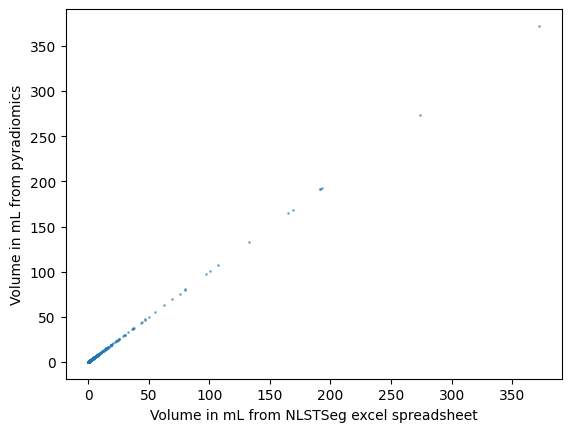

In [ ]:
# Now plot

nlstseg_values = df_join['Tumor_V(cm3)'].values
pyradiomics_values = df_join['Value_mod'].values

diff_values = nlstseg_values - pyradiomics_values
df_join['volume_diff'] = df_join['Tumor_V(cm3)'].values - df_join['Value_mod'].values

avg_diff = np.mean(diff_values)
min_diff = np.min(diff_values)
max_diff = np.max(diff_values)
std_diff = np.std(diff_values)
print('avg_diff: ' + str(avg_diff))
print('min_diff: ' + str(min_diff))
print('max_diff: ' + str(max_diff))
print('std_diff: ' + str(std_diff))

plt.figure()
plt.scatter(nlstseg_values, pyradiomics_values, s=1, alpha=0.5)
plt.xlabel('Volume in mL from NLSTSeg excel spreadsheet')
plt.ylabel('Volume in mL from pyradiomics')
plt.show()

In [ ]:
print(np.corrcoef(nlstseg_values,pyradiomics_values))

[[1.         0.99999999]
 [0.99999999 1.        ]]
